from collections import Counter
# Cricket Image Classification: Feature Extraction & Model Training

This notebook demonstrates the complete pipeline for classifying cricket image cells (Ball, Bat, Stump, Background).

## Steps:
1.  **Setup**: Install dependencies.
2.  **Data Loading**: Load images and labels.
3.  **Feature Visualization**: Inspect HOG, Color, and Shape features.
4.  **Feature Extraction**: Build the feature matrix.
5.  **Model Training**: Train SVM, Random Forest, and MLP classifiers.
6.  **Evaluation**: Analyze performance metrics.

## 1. Setup & Dependencies

In [167]:
!pip install scikit-image opencv-python pandas matplotlib scikit-learn


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [168]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Configuration
IMG_WIDTH = 800
IMG_HEIGHT = 600
GRID_ROWS = 8
GRID_COLS = 8
CELL_W = IMG_WIDTH // GRID_COLS
CELL_H = IMG_HEIGHT // GRID_ROWS

# Paths (Adjust if using Google Drive)
PROCESSED_DIR = "processed_images"
LABELS_FILE = "labels.csv"

## 2. Data Loading
Ensure `processed_images` folder and `labels.csv` are uploaded to the Colab environment.

In [169]:
def load_data(labels_file, image_dir):
    if not os.path.exists(labels_file):
        print(f"Error: {labels_file} not found.")
        return None
    
    df = pd.read_csv(labels_file)
    print(f"Loaded labels for {len(df)} images.")
    return df

df = load_data(LABELS_FILE, PROCESSED_DIR)
df.head()

Loaded labels for 61 images.


,ImageFileName,TrainOrTest,c01,c02,c03,c04,c05,c06,c07,c08,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
0,Screenshot 2025-11-02 104948.jpg,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,d776ac3d-0ba3-47be-84dc-24af35be3c4c.jpg,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,3,3,2,0,0,0
2,a644afcb-a5f8-4400-8606-d08f8c8ae9ba.jpg,Train,0,0,0,2,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
3,pexels-arsal-point-356971417-31131697.jpg,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
4,Screenshot-2024-05-22-at-4.04.57-PM-1024x675.png,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Feature Visualization
Let's inspect the features for a single cell to understand what the model sees.

In [243]:
def visualize_features(image_name, row_idx, col_idx):
    img_path = os.path.join(PROCESSED_DIR, image_name)
    if not os.path.exists(img_path):
        print(f"Image {image_name} not found.")
        return
        
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extract Cell
    x1 = col_idx * CELL_W
    y1 = row_idx * CELL_H
    x2 = x1 + CELL_W
    y2 = y1 + CELL_H
    cell = img[y1:y2, x1:x2]
    
    # Changed to 2x4 grid to accommodate LBP
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # 1. Original
    axes[0, 0].imshow(cell)
    axes[0, 0].set_title("Original Cell")
    axes[0, 0].axis('off')
    
    # 2. HOG
    fd, hog_image = hog(cell, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    axes[0, 1].imshow(hog_image_rescaled, cmap='gray')
    axes[0, 1].set_title("HOG Features")
    axes[0, 1].axis('off')
    
    # 3. Color Histogram
    axes[0, 2].set_title("Color Histogram")
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([cell], [i], None, [32], [0, 256])
        axes[0, 2].plot(hist, color=color)
        
    # 4. Edge Detection
    gray = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 200)
    axes[1, 0].imshow(edges, cmap='gray')
    axes[1, 0].set_title("Canny Edges")
    axes[1, 0].axis('off')
    
    # 5. Hough Lines
    lines_img = cell.copy()
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=20, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1_l, y1_l, x2_l, y2_l = line[0]
            cv2.line(lines_img, (x1_l, y1_l), (x2_l, y2_l), (0, 255, 0), 2)
    axes[1, 1].imshow(lines_img)
    axes[1, 1].set_title("Hough Lines")
    axes[1, 1].axis('off')
    
    # 6. Hough Circles
    circles_img = cell.copy()
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=70, param2=5, minRadius=6, maxRadius=6)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(circles_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(circles_img, (i[0], i[1]), 2, (255, 0, 0), 3)
    axes[1, 2].imshow(circles_img)
    axes[1, 2].set_title("Hough Circles")
    axes[1, 2].axis('off')
    
    # 7. LBP (Local Binary Pattern)
    # Parameters: P=8, R=1 is standard for 3x3 neighborhood
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    axes[0, 3].imshow(lbp, cmap='gray')
    axes[0, 3].set_title("LBP Texture")
    axes[0, 3].axis('off')
    
    # Hide unused subplot
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()


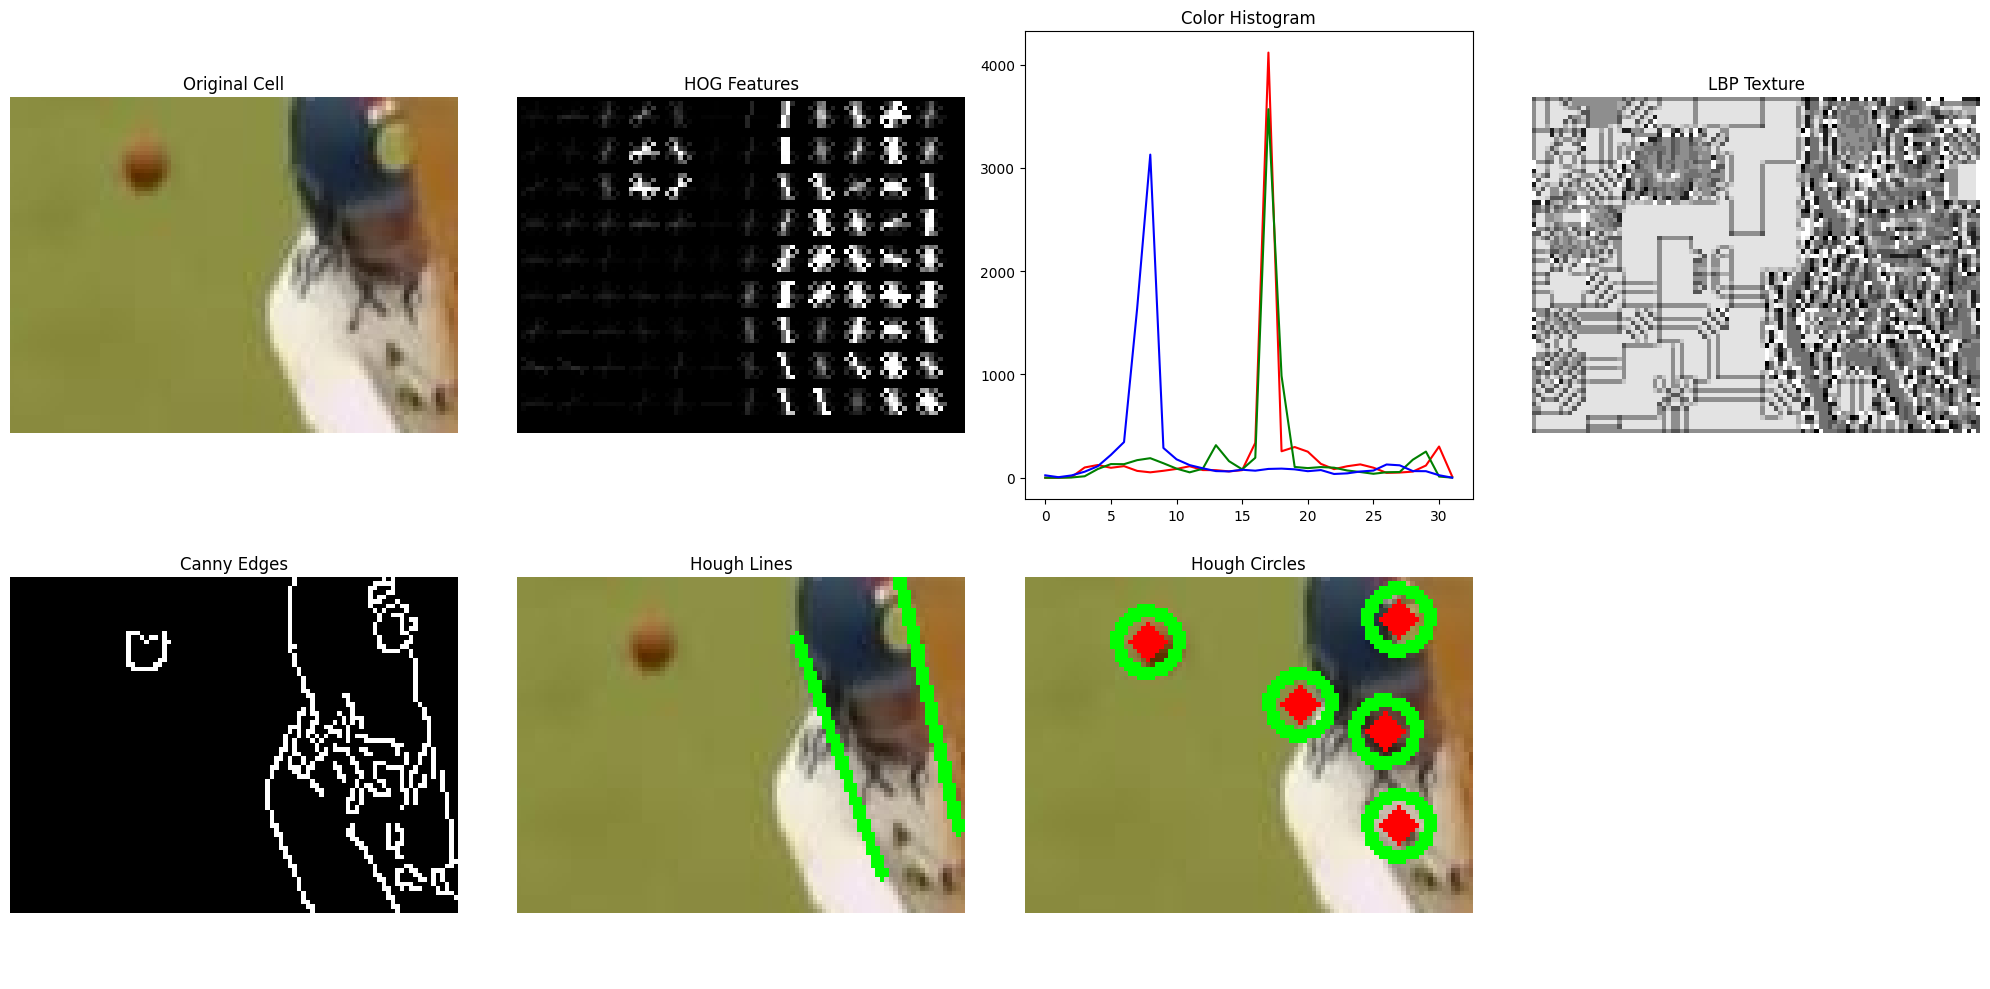

In [244]:
visualize_features(df['ImageFileName'].head()[0], 3, 3)

In [209]:
df['ImageFileName'].head()[0]

'Screenshot 2025-11-02 104948.jpg'

## 4. Feature Extraction
We will now iterate through all images and extract features for every labeled cell.

In [238]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.feature import local_binary_pattern

# Configuration
IMG_WIDTH = 800
IMG_HEIGHT = 600
GRID_ROWS = 8
GRID_COLS = 8
CELL_W = IMG_WIDTH // GRID_COLS
CELL_H = IMG_HEIGHT // GRID_ROWS
PROCESSED_DIR = "processed_images"
LABELS_FILE = "labels.csv"

def extract_features(df):
    features_list = []
    labels_list = []
    meta_list = []

    print("Starting feature extraction...")

    for idx, row in df.iterrows():
        img_name = row['ImageFileName']
        img_path = os.path.join(PROCESSED_DIR, img_name)

        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
            
        # FIX 1: Resize image to ensure consistent dimensions
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for i in range(64):
            label = row[f"c{i+1:02d}"]
            
            r = i // GRID_COLS
            c = i % GRID_COLS

            x1 = c * CELL_W
            y1 = r * CELL_H
            x2 = x1 + CELL_W
            y2 = y1 + CELL_H

            cell = img[y1:y2, x1:x2]

            # --- Feature 1: HOG ---
            fd = hog(cell, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=False, channel_axis=-1)

            # --- Feature 2: Color Histogram ---
            hist_features = []
            for ch in range(3):
                hist = cv2.calcHist([cell], [ch], None, [32], [0, 256])
                hist = cv2.normalize(hist, hist).flatten()
                hist_features.extend(hist)

            # --- Feature 3: Shape Counts ---
            gray = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 50, 150)

            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=20, maxLineGap=10)
            num_lines = len(lines) if lines is not None else 0

            circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                                       param1=50, param2=30, minRadius=5, maxRadius=50)
            # Check if circles is None before accessing index
            num_circles = len(circles[0, :]) if circles is not None else 0

            # --- Feature 4: LBP (Texture) ---
            # P=8, R=1. Method='uniform' gives 10 bins for P=8
            lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
            
            # FIX 2: Fixed n_bins to 10 for P=8 uniform LBP
            n_bins = 10
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

            # Combine
            combined = np.concatenate([fd, hist_features, [num_lines, num_circles], lbp_hist])

            features_list.append(combined)
            labels_list.append(label)
            meta_list.append((img_name, i))

    return np.array(features_list), np.array(labels_list), meta_list

if __name__ == "__main__":
    if os.path.exists(LABELS_FILE):
        df = pd.read_csv(LABELS_FILE)
        # Test on a small subset
        df_subset = df.head(3) 
        try:
            X, y, meta = extract_features(df_subset)
            print("Feature extraction successful!")
            print(f"Feature matrix shape: {X.shape}")
        except Exception as e:
            print(f"Error during feature extraction: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Labels file not found: {LABELS_FILE}")


Starting feature extraction...
Feature extraction successful!
Feature matrix shape: (192, 3276)


## 4.1 Feature Space Analysis (PCA & t-SNE)
We perform dimensionality reduction to visualize the feature space and class separability.
- **PCA**: To analyze variance explained by components.
- **t-SNE**: To visualize high-dimensional data in 2D.

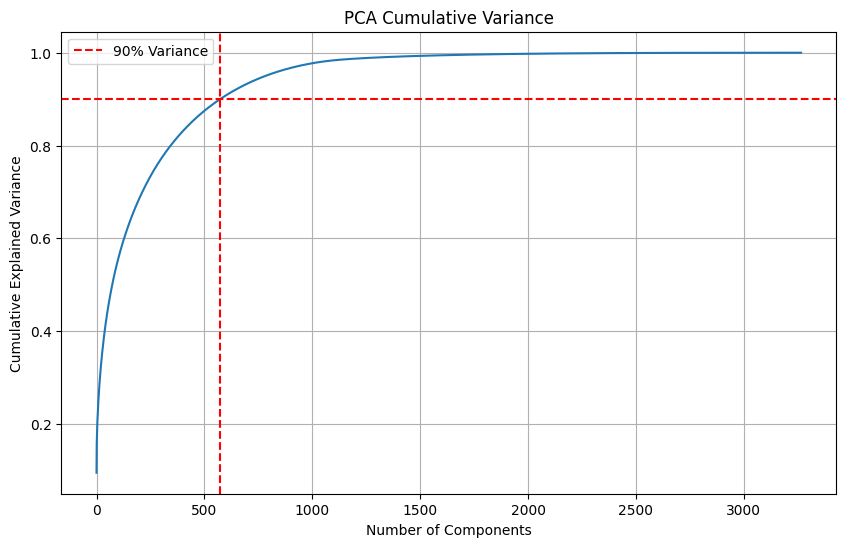

Number of components explaining 90% variance: 574
Using top 50 PCA components for t-SNE initialization


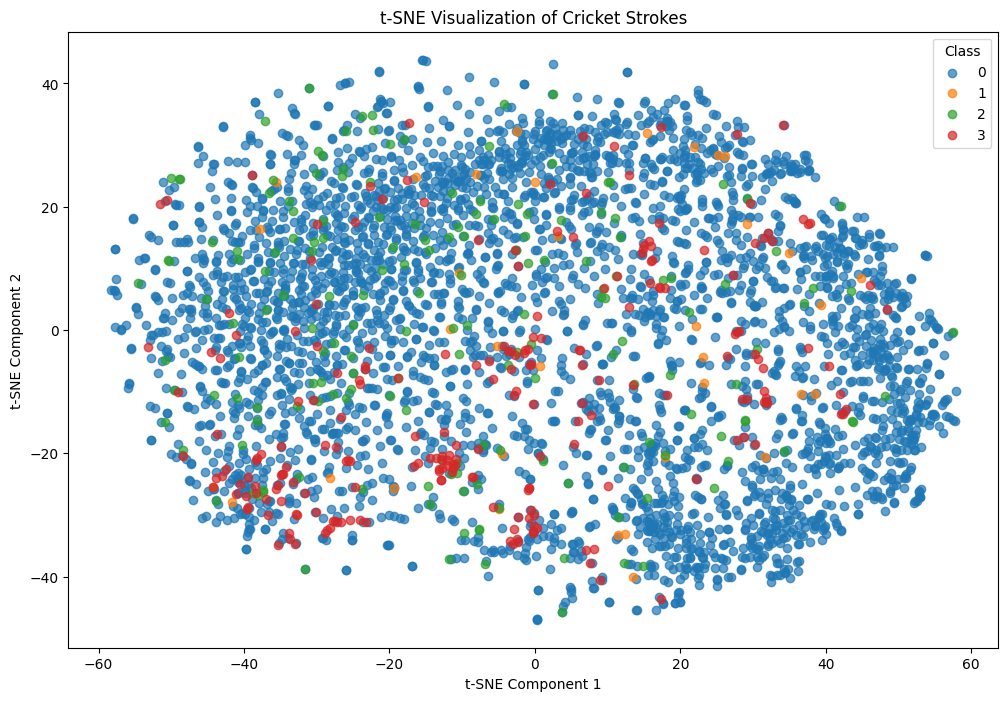

In [ ]:
# Standardize features for visualization
scaler_viz = StandardScaler()
X_scaled_viz = scaler_viz.fit_transform(X)

# --- PCA Analysis ---
pca = PCA()
pca.fit(X_scaled_viz)

# Plot Cumulative Variance
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Variance')
plt.grid(True)

# Find components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.axvline(x=n_components_90, color='r', linestyle='--')
plt.legend()
plt.show()

print(f"Number of components explaining 90% variance: {n_components_90}")

# --- t-SNE Visualization ---
# Use PCA to reduce dimensions first (speed + noise reduction)
n_components_tsne_input = min(n_components_90, 50)
print(f"Using top {n_components_tsne_input} PCA components for t-SNE initialization")

pca_tsne = PCA(n_components=n_components_tsne_input)
X_pca_tsne = pca_tsne.fit_transform(X_scaled_viz)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca_tsne)

# Plot t-SNE
plt.figure(figsize=(12, 8))
unique_labels = np.unique(y)
for label in unique_labels:
    indices = np.where(y == label)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=label, alpha=0.7)

plt.title('t-SNE Visualization of Cricket Strokes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class')
plt.show()

## 4.1 Exploratory Data Analysis (EDA)
Let's analyze the class distribution and feature correlations.

## 4.1 Data Splitting
We split the data into training and testing sets before EDA to avoid data leakage.

In [ ]:
# Split Data
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (3123, 3266)
Test set: (781, 3266)


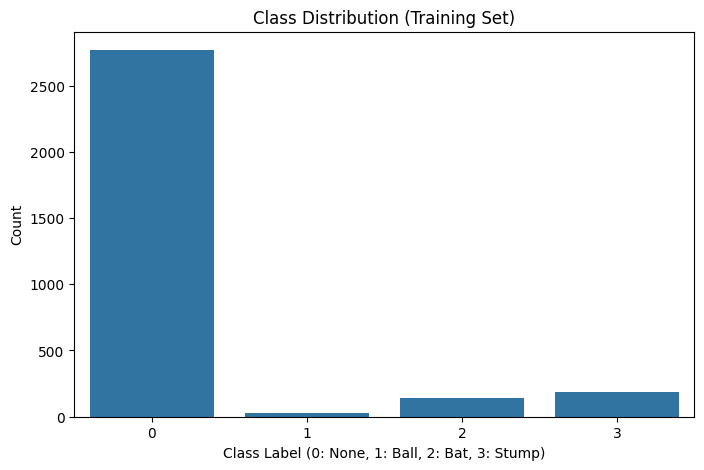

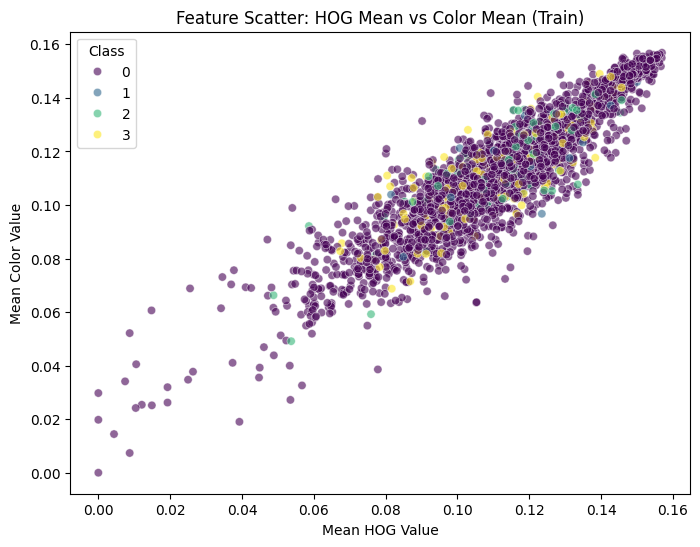

In [ ]:
import seaborn as sns

# 1. Class Distribution (Train Data)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution (Training Set)")
plt.xlabel("Class Label (0: None, 1: Ball, 2: Bat, 3: Stump)")
plt.ylabel("Count")
plt.show()

# 2. Feature Correlation (Subset - Train Data)
# We have many features, let's look at HOG mean vs Color mean
hog_means = np.mean(X_train[:, :324], axis=1)
color_means = np.mean(X_train[:, 324:324+768], axis=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=hog_means, y=color_means, hue=y_train, palette='viridis', alpha=0.6)
plt.title("Feature Scatter: HOG Mean vs Color Mean (Train)")
plt.xlabel("Mean HOG Value")
plt.ylabel("Mean Color Value")
plt.legend(title="Class")
plt.show()

## 4.2 Handling Class Imbalance (SMOTE)
We use SMOTE to oversample the minority classes in the training set.

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Original class distribution:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Resampled class distribution:", Counter(y_train_resampled))

# Update training data to use resampled data for models
# Note: X_train_scaled was already scaled before SMOTE if we follow the split cell logic
# But wait, the split cell does scaling AFTER splitting usually. Let's check the split cell content.


Original class distribution: Counter({0: 2768, 3: 187, 2: 140, 1: 28})
Resampled class distribution: Counter({0: 2768, 2: 2768, 3: 2768, 1: 2768})


In [ ]:
# 1. Support Vector Machine
print("Training SVM...")
svm_model = SVC(probability=True, kernel='rbf', C=10, gamma='scale', class_weight='balanced')
svm_model.fit(X_train_resampled, y_train_resampled)
svm_pred = svm_model.predict(X_test_scaled)
svm_train_pred = svm_model.predict(X_train_scaled)
print("svm Train Accuracy:", accuracy_score(y_train, svm_train_pred))
print("SVM Test Accuracy:", accuracy_score(y_test, svm_pred))

Training SVM...
svm Train Accuracy: 1.0
SVM Test Accuracy: 0.9014084507042254


In [ ]:
# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_pred = rf_model.predict(X_test_scaled)
rf_train_pred = rf_model.predict(X_train_scaled)
print("rf Train Accuracy:", accuracy_score(y_train, rf_train_pred))
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_pred))

Training Random Forest...
rf Train Accuracy: 1.0
Random Forest Test Accuracy: 0.8847631241997439


In [ ]:
# 3. MLP (Neural Network)
print("Training MLP...")
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_resampled, y_train_resampled)
mlp_pred = mlp_model.predict(X_test_scaled)
mlp_train_pred = mlp_model.predict(X_train_scaled)
print("mlp Train Accuracy:", accuracy_score(y_train, mlp_train_pred))
print("MLP Test Accuracy:", accuracy_score(y_test, mlp_pred))

Training MLP...
mlp Train Accuracy: 1.0
MLP Test Accuracy: 0.8898847631241997


## 6. Evaluation
Visualizing the performance of the best model (likely Random Forest or SVM).

--- SVM Evaluation ---

Train Classification Report:
              precision    recall  f1-score   support

        None       1.00      1.00      1.00      2768
        Ball       1.00      1.00      1.00      2768
         Bat       1.00      1.00      1.00      2768
       Stump       1.00      1.00      1.00      2768

    accuracy                           1.00     11072
   macro avg       1.00      1.00      1.00     11072
weighted avg       1.00      1.00      1.00     11072



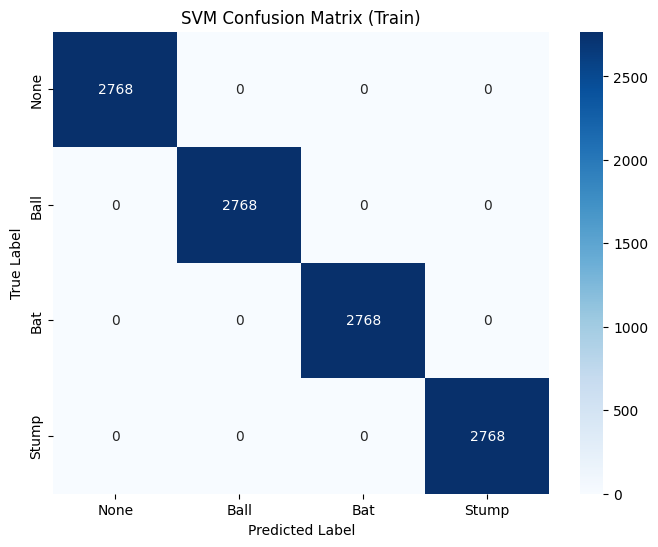


Test Classification Report:
              precision    recall  f1-score   support

        None       0.90      1.00      0.95       701
        Ball       0.00      0.00      0.00         7
         Bat       0.00      0.00      0.00        35
       Stump       0.67      0.16      0.26        38

    accuracy                           0.90       781
   macro avg       0.39      0.29      0.30       781
weighted avg       0.84      0.90      0.86       781



/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

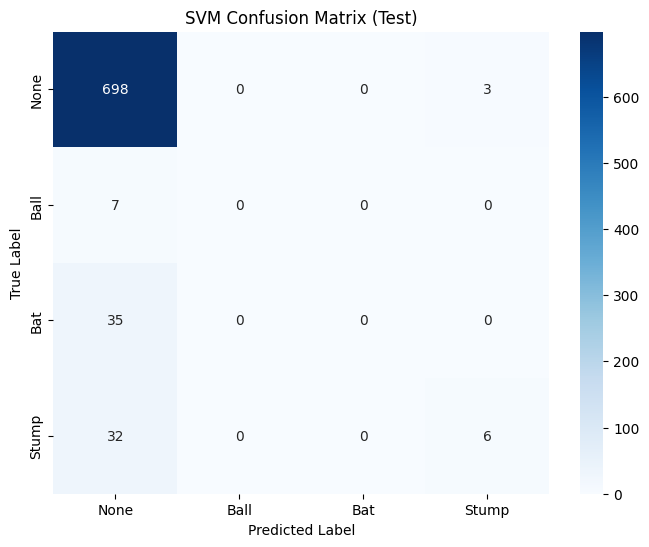

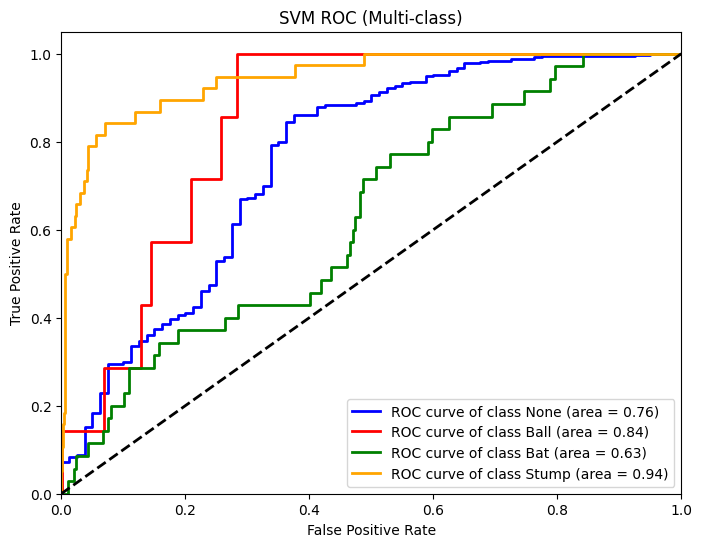

--- Random Forest Evaluation ---

Train Classification Report:
              precision    recall  f1-score   support

        None       1.00      1.00      1.00      2768
        Ball       1.00      1.00      1.00      2768
         Bat       1.00      1.00      1.00      2768
       Stump       1.00      1.00      1.00      2768

    accuracy                           1.00     11072
   macro avg       1.00      1.00      1.00     11072
weighted avg       1.00      1.00      1.00     11072



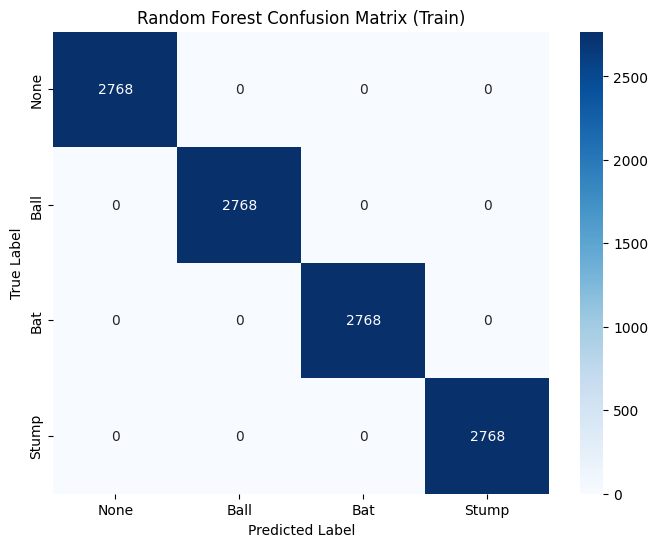


Test Classification Report:
              precision    recall  f1-score   support

        None       0.91      0.97      0.94       701
        Ball       0.00      0.00      0.00         7
         Bat       0.20      0.09      0.12        35
       Stump       0.44      0.21      0.29        38

    accuracy                           0.88       781
   macro avg       0.39      0.32      0.34       781
weighted avg       0.85      0.88      0.86       781



/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

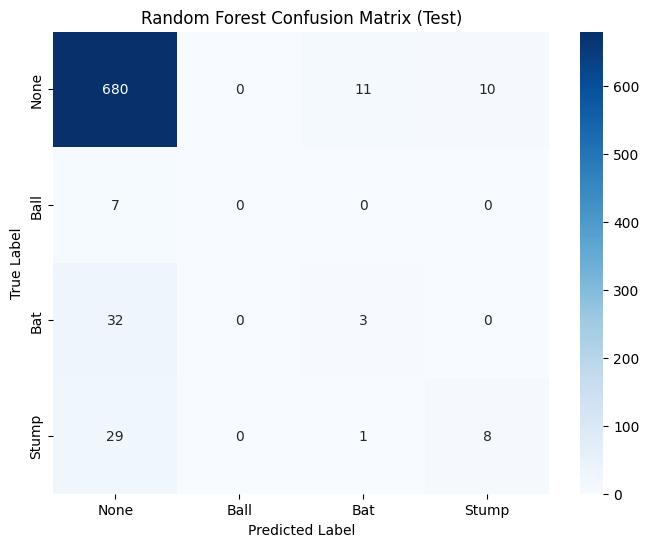

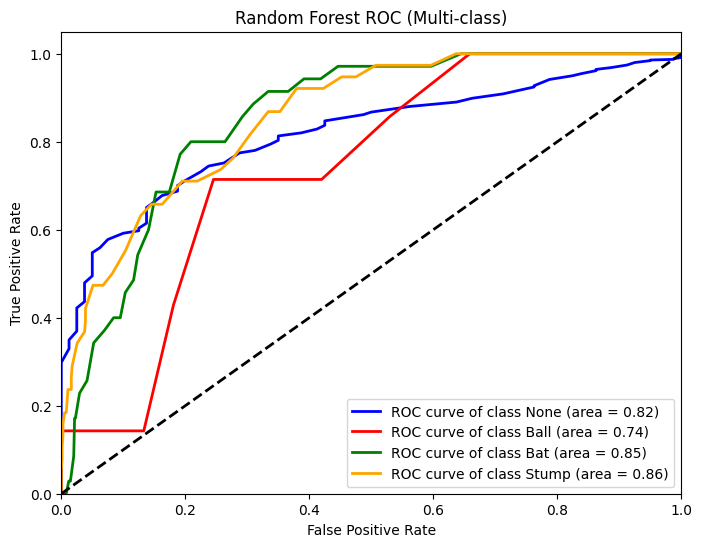

--- MLP Evaluation ---

Train Classification Report:
              precision    recall  f1-score   support

        None       1.00      1.00      1.00      2768
        Ball       1.00      1.00      1.00      2768
         Bat       1.00      1.00      1.00      2768
       Stump       1.00      1.00      1.00      2768

    accuracy                           1.00     11072
   macro avg       1.00      1.00      1.00     11072
weighted avg       1.00      1.00      1.00     11072



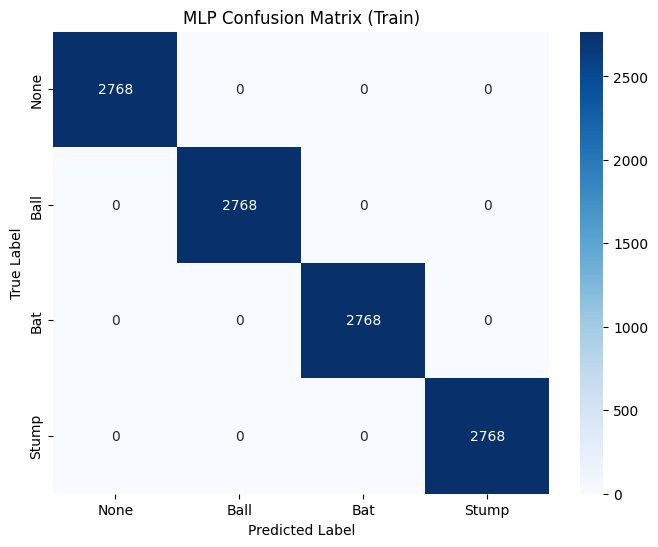


Test Classification Report:
              precision    recall  f1-score   support

        None       0.92      0.97      0.94       701
        Ball       0.00      0.00      0.00         7
         Bat       0.15      0.06      0.08        35
       Stump       0.62      0.42      0.50        38

    accuracy                           0.89       781
   macro avg       0.42      0.36      0.38       781
weighted avg       0.86      0.89      0.87       781



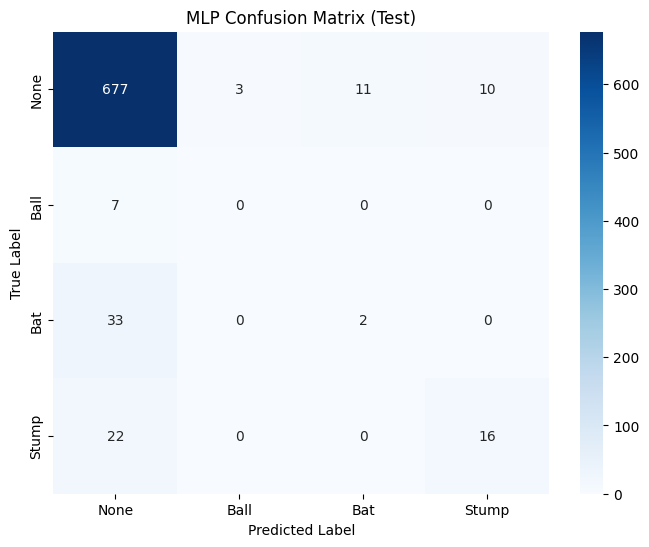

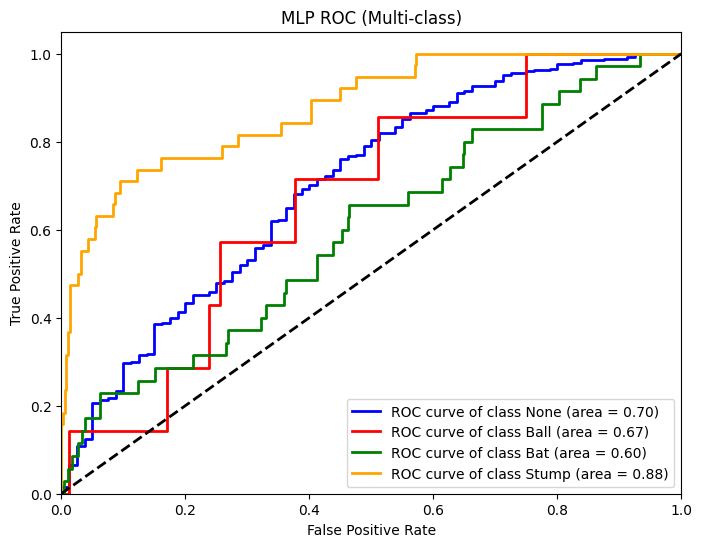

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    print(f"--- {name} Evaluation ---")
    
    # --- Predictions ---
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # --- Class-wise Metrics (Train) ---
    print("\nTrain Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=['None', 'Ball', 'Bat', 'Stump']))
    plot_confusion_matrix(y_train, y_train_pred, f"{name} Confusion Matrix (Train)")
    
    # --- Class-wise Metrics (Test) ---
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['None', 'Ball', 'Bat', 'Stump']))
    plot_confusion_matrix(y_test, y_test_pred, f"{name} Confusion Matrix (Test)")
    
    # --- ROC Graph ---
    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(X_test)
        
        # Binarize the output
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
        n_classes = y_test_bin.shape[1]
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Plot ROC
        plt.figure(figsize=(8, 6))
        colors = cycle(['blue', 'red', 'green', 'orange'])
        class_names = ['None', 'Ball', 'Bat', 'Stump']
        
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))
                     
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"{name} does not support predict_proba, skipping ROC.")

evaluate_model(svm_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, "SVM")
evaluate_model(rf_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, "Random Forest")
evaluate_model(mlp_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, "MLP")

## 7. Save Predictions
Save the test set predictions to a CSV file for review.

In [ ]:
# Predict on ALL data to generate complete image labels
print("Predicting on full dataset...")
X_scaled = scaler.transform(X)
all_pred = rf_model.predict(X_scaled)

# Create results DataFrame in wide format (matching labels.csv)
results_map = {}

for (img, cell_idx), pred_lbl in zip(meta, all_pred):
    if img not in results_map:
        results_map[img] = [0] * 64
    results_map[img][cell_idx] = pred_lbl

csv_rows = []
for img, preds in results_map.items():
    row = {'ImageFileName': img, 'TrainOrTest': 'Predicted'}
    for i, val in enumerate(preds):
        row[f'c{i+1:02d}'] = val
    csv_rows.append(row)

predicted_df = pd.DataFrame(csv_rows)
# Ensure columns are in correct order
cols = ['ImageFileName', 'TrainOrTest'] + [f'c{i+1:02d}' for i in range(64)]
predicted_df = predicted_df[cols]

predicted_df.to_csv("predicted_labels.csv", index=False)
print(f"Saved predictions for {len(predicted_df)} images to predicted_labels.csv")
predicted_df.head()

Predicting on full dataset...
Saved predictions for 61 images to predicted_labels.csv


,ImageFileName,TrainOrTest,c01,c02,c03,c04,c05,c06,c07,c08,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
0,Screenshot 2025-11-02 104948.jpg,Predicted,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,d776ac3d-0ba3-47be-84dc-24af35be3c4c.jpg,Predicted,0,0,0,0,0,0,0,0,...,0,0,0,0,3,3,0,0,0,0
2,a644afcb-a5f8-4400-8606-d08f8c8ae9ba.jpg,Predicted,0,0,0,2,0,0,0,0,...,0,0,0,0,0,3,3,0,0,0
3,pexels-arsal-point-356971417-31131697.jpg,Predicted,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
4,Screenshot-2024-05-22-at-4.04.57-PM-1024x675.png,Predicted,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
